# ***Question 2 - Biggest strides in decreasing CO<sub>2</sub>***

At first I'm importing the required packages so I can write my code clearly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb as ddb

Here I'm getting the needed data from a raw data source, with checking if the data loads like it should. 

By using the raw data source it is readable not only by me and also when the data updates, I can do the same analysis with the updated information without the need to download new files, this improves my efficiency in workflow.

I've chosen this data source because these are relations that are commonly announced in media and other information sources.

In [2]:
# import data
df_co2 = pd.read_csv("https://ourworldindata.org/grapher/annual-co2-emissions-per-country.csv?v=1&csvType=full&useColumnShortNames=false")
df_pop = pd.read_csv("https://ourworldindata.org/grapher/population.csv?v=1&csvType=full&useColumnShortNames=true")
df_co2_pc = pd.read_csv("https://ourworldindata.org/grapher/co2-emissions-per-capita.csv?v=1&csvType=full&useColumnShortNames=false")
# df_co2.head()
# df_pop.head()
# df_co2_pc.head()

I'm selecting 2 years 10 years apart for this analysis to rule out coincidences. A longer term will probably yield more robust conclusions.

I'm using duckdb (ddb) because it makes selecting the required years easy with a syntax I'm quite familiar with.

In [3]:
df_co2 = ddb.query("""
    SELECT *
    FROM df_co2
    where year in (2013, 2023)
""").to_df()

In this tab I will change the names of the columns, to improve the workflow.

I'm also merging the different dataframes on 'code' and 'year', I do this to work with on a single dataframe.


In [4]:
# Rename columns
df_co2.rename(columns={'Annual CO₂ emissions': "CO2"}, inplace=True)
df_pop.rename(columns={'population_historical': "Pop"}, inplace=True)
df_co2_pc.rename(columns={'Annual CO₂ emissions (per capita)': "CO2_pc"}, inplace=True)

# Merge dataframes
df_merged = pd.merge(df_co2, df_pop.drop(columns = ['Entity']) ,how='left', on=['Code', 'Year'])
df_merged = pd.merge(df_merged, df_co2_pc.drop(columns = ['Entity']), how='left', on=['Code', 'Year'])
df_final = df_merged.copy()
df_final.head()

,Entity,Code,Year,CO2,Pop,CO2_pc
0,Afghanistan,AFG,2013,8.891447e+06,3.162271e+07,0.281173
1,Afghanistan,AFG,2023,1.051632e+07,4.145476e+07,0.253682
2,Africa,None,2013,1.280567e+09,1.158781e+09,1.106561
3,Africa,None,2013,1.280567e+09,1.158781e+09,4.258548
4,Africa,None,2013,1.280567e+09,1.158781e+09,3.939337


Per cap means 'CO<sub>2</sub>' / 'pop'

In [5]:
df_final['change_co2_per_cap'] = df_final.groupby('Entity')['CO2_pc'].diff()

df_final.head(200)


,Entity,Code,Year,CO2,Pop,CO2_pc,change_co2_per_cap
0,Afghanistan,AFG,2013,8.891447e+06,3.162271e+07,0.281173,NaN
1,Afghanistan,AFG,2023,1.051632e+07,4.145476e+07,0.253682,-0.027491
2,Africa,None,2013,1.280567e+09,1.158781e+09,1.106561,NaN
3,Africa,None,2013,1.280567e+09,1.158781e+09,4.258548,3.151987
4,Africa,None,2013,1.280567e+09,1.158781e+09,3.939337,-0.319212
...,...,...,...,...,...,...,...
195,Africa,None,2013,1.280567e+09,5.613457e+08,4.258548,3.151987
196,Africa,None,2013,1.280567e+09,5.613457e+08,3.939337,-0.319212
197,Africa,None,2013,1.280567e+09,5.613457e+08,7.867500,3.928164
198,Africa,None,2013,1.280567e+09,5.613457e+08,8.881309,1.013809


I'm ruling out the rows with missing values so I can work wit a clean dataset, missing values could affect my conclusion because of missing datapoints.

In [6]:
df_final = df_final[df_final['Code'].notna()]

I've added a percentage change column to see the relative change in emission.

In [7]:
#Calculate percentage change in CO2 emission and population
# Use 2013 values (first value in each group) as the baseline
df_final['CO2_pc_2013'] = df_final.groupby('Entity')['CO2_pc'].transform('first')
df_final['% Change Emission'] = round(((df_final['change_co2_per_cap'] / df_final['CO2_pc_2013'])*100),2)

df_final.head(2000)


,Entity,Code,Year,CO2,Pop,CO2_pc,change_co2_per_cap,CO2_pc_2013,% Change Emission
0,Afghanistan,AFG,2013,8891447.0,31622709.0,0.281173,NaN,0.281173,NaN
1,Afghanistan,AFG,2023,10516319.0,41454762.0,0.253682,-0.027491,0.281173,-9.78
1154,Albania,ALB,2013,5346089.0,2907571.0,1.838679,NaN,1.838679,NaN
1155,Albania,ALB,2023,4417333.0,2811660.0,1.571076,-0.267602,1.838679,-14.55
1156,Algeria,DZA,2013,141534270.0,38414176.0,3.684428,NaN,3.684428,NaN
...,...,...,...,...,...,...,...,...,...
17709,Yemen,YEM,2023,10141169.0,39390800.0,0.257450,-0.673231,0.930681,-72.34
17710,Zambia,ZMB,2013,4426548.0,15399000.0,0.287457,NaN,0.287457,NaN
17711,Zambia,ZMB,2023,11830727.0,20723967.0,0.570872,0.283415,0.287457,98.59
17712,Zimbabwe,ZWE,2013,11671374.0,14013811.0,0.832848,NaN,0.832848,NaN


Now i have cleaned my dataset from missing values by selecting only 2023.

In [8]:
df_final = df_final[df_final['Year'].eq(2023)]

For the final analysis I'm creating a graph to see which country has the highest decrease in CO<sub>2</sub> output per capita to eliminate population size effects.

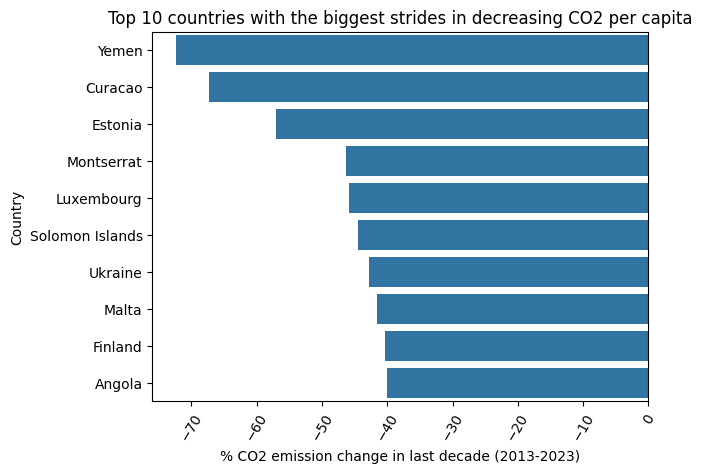

In [9]:
# df = sns.load_dataset('df_final22')
top10 = df_final.sort_values(by='% Change Emission', ascending=True).head(10)
ax = sns.barplot(x = '% Change Emission',y = 'Entity',data = top10)
plt.xticks(rotation=60)
# ax.bar_label(ax.containers[0])
plt.title('Top 10 countries with the biggest strides in decreasing CO2 per capita')
plt.xlabel('% CO2 emission change in last decade (2013-2023)')
plt.ylabel('Country')
plt.show()

As you can see above, Yemen has the largest decrease in capita in the last decade.

# ***conclusion***

Yemen makes the biggest strides in decreasing CO<sub>2</sub> when I look to the last decade.